In [30]:
import os 
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [31]:
def remove_columns(df_name):
    columns_to_remove = ['Location', 'Next_date', 'Month', 'Year']
    if isinstance(df_name, pd.DataFrame):
        return df_name.drop(columns=columns_to_remove, errors='ignore')
    else:
        raise ValueError("Input is not a pandas DataFrame.")



In [32]:
def convert_to_datetime(df):
    df['Current_date'] = pd.to_datetime(df['Current_date'])
    return df


# colombo


In [33]:
colombo = pd.read_csv('Colombo_Hcho_Reading.csv')
colombo

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000197,Colombo,2019-01-01,2019-01-02,1,2019
1,0.000263,Colombo,2019-01-02,2019-01-03,1,2019
2,0.000099,Colombo,2019-01-03,2019-01-04,1,2019
3,0.000210,Colombo,2019-01-04,2019-01-05,1,2019
4,0.000179,Colombo,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000118,Colombo,2023-12-27,2023-12-28,12,2023
1822,0.000177,Colombo,2023-12-28,2023-12-29,12,2023
1823,0.000177,Colombo,2023-12-29,2023-12-30,12,2023
1824,0.000140,Colombo,2023-12-30,2023-12-31,12,2023


In [34]:
colombo = remove_columns(colombo)
convert_to_datetime(colombo)
colombo 

,HCHO_reading,Current_date
0,0.000197,2019-01-01
1,0.000263,2019-01-02
2,0.000099,2019-01-03
3,0.000210,2019-01-04
4,0.000179,2019-01-05
...,...,...
1821,0.000118,2023-12-27
1822,0.000177,2023-12-28
1823,0.000177,2023-12-29
1824,0.000140,2023-12-30


In [35]:
colombo.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [36]:
split_colombo = int(len(colombo) * 0.8)
colombo_train, colombo_test = colombo.iloc[:split_colombo], colombo.iloc[split_colombo:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-23868.300, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23102.901, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23523.603, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-23846.306, Time=4.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23104.950, Time=0.12 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-23870.169, Time=11.78 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-23874.849, Time=1.67 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-23873.111, Time=3.70 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-23879.366, Time=1.52 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-23877.622, Time=2.94 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-23874.714, Time=3.34 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-23872.846, Time=3.50 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-23879.697, Time=0.26 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-23877.953, Time

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(0, 1, 4)x(0, 1, 4, 12)   Log Likelihood               11330.360
Date:                            Fri, 19 Apr 2024   AIC                         -22642.720
Time:                                    09:41:15   BIC                         -22595.225
Sample:                                         0   HQIC                        -22624.995
                                           - 1460                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8201   3.34e-19  -2.45e+18      0.000      -0.820      -0.820
ma.L2         -0.0024   3.94e-19   

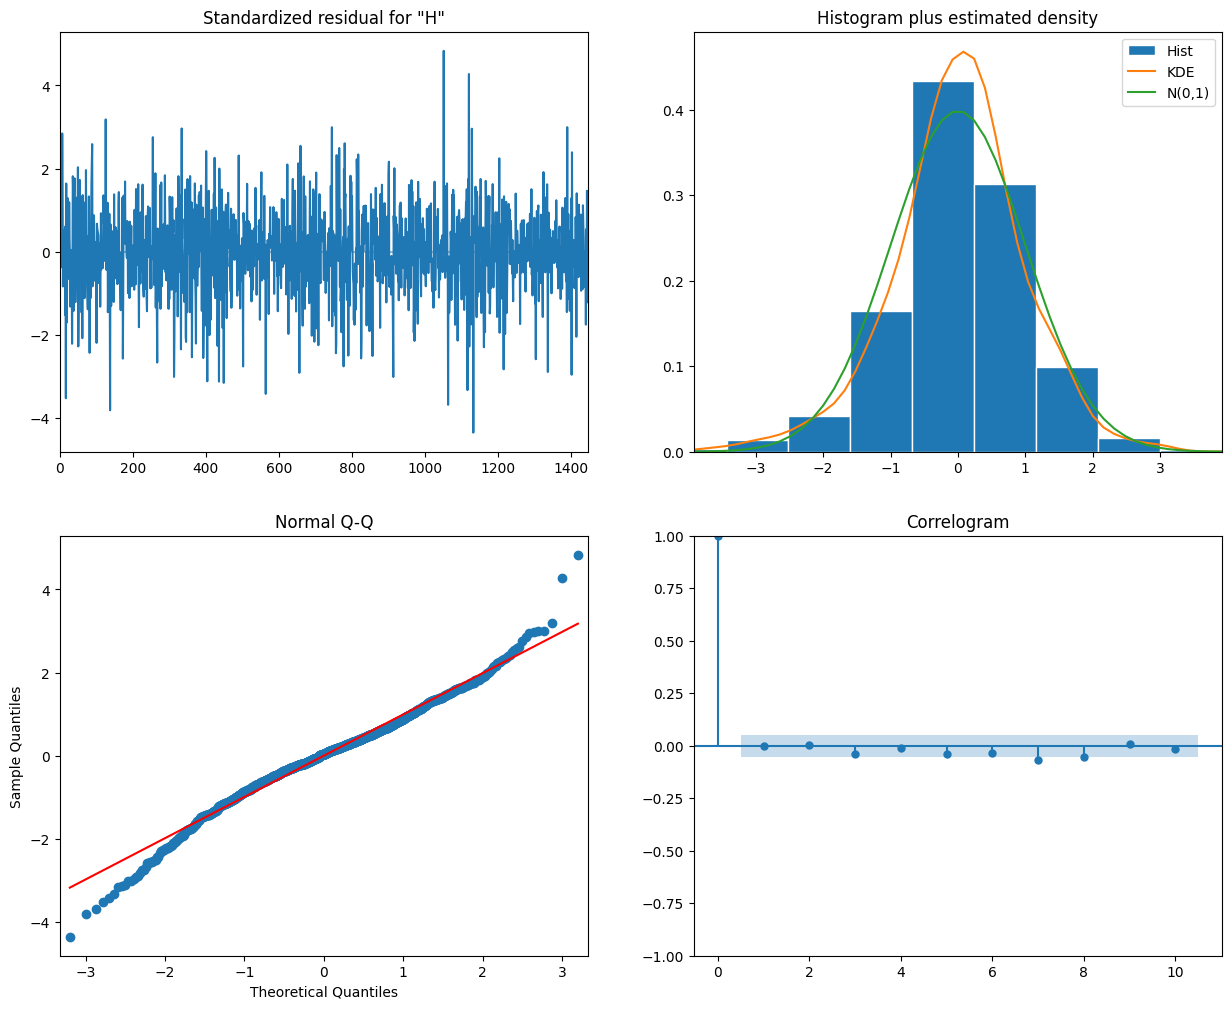

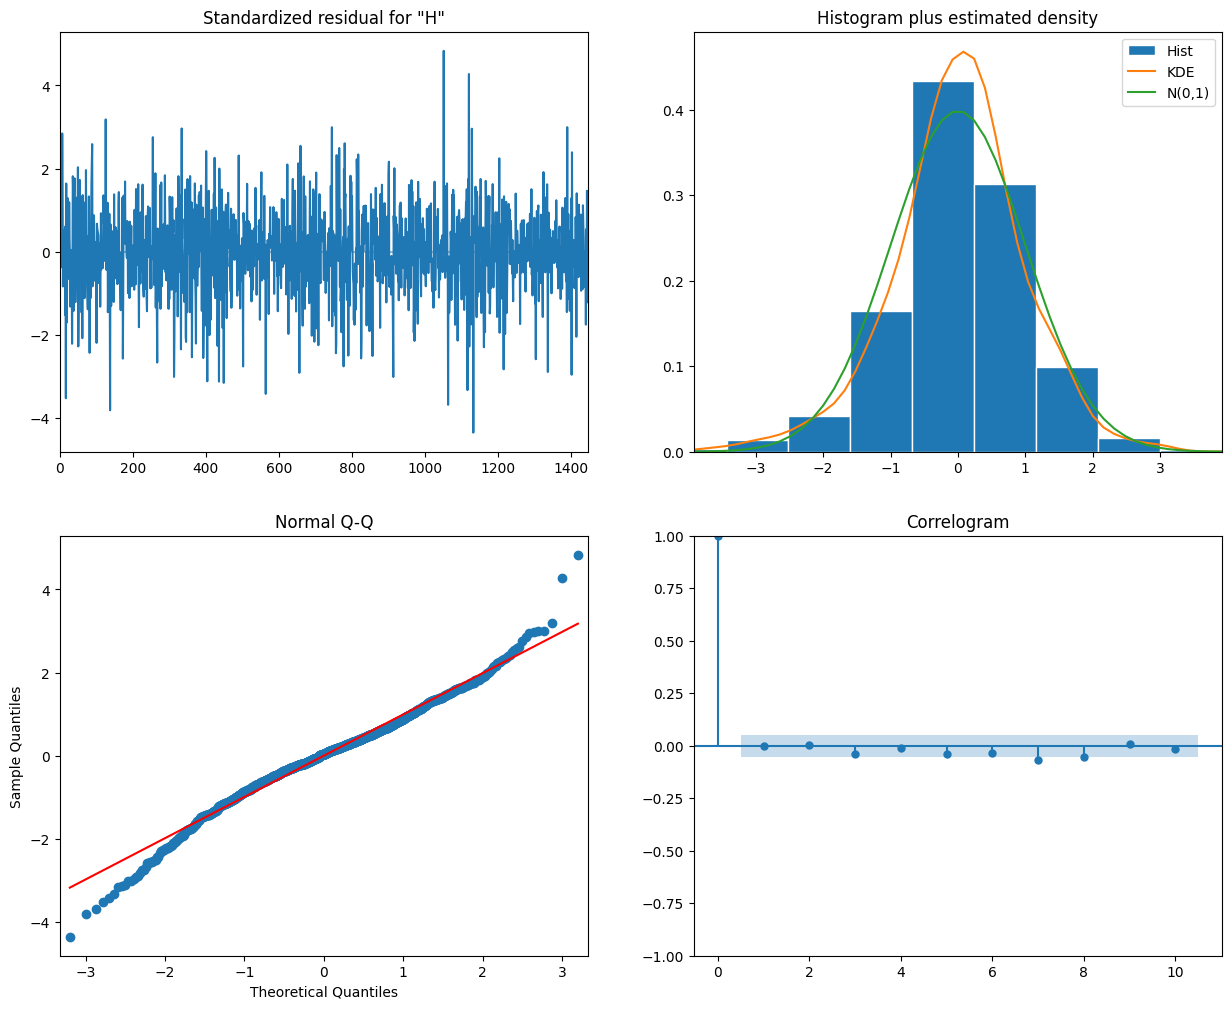

In [37]:
colombo_model = auto_arima(colombo_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = colombo_model.order
print(p,d,q)
colombo_sarima = SARIMAX(colombo_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
colombo_sarima_fit = colombo_sarima.fit()
print(colombo_sarima_fit.summary())
colombo_sarima_fit.plot_diagnostics(figsize=(15,12))

In [38]:
colombo_test_preds_sarima = colombo_sarima_fit.forecast(steps=len(colombo_test))
colombo_sarima_mse = mean_squared_error(colombo_test['HCHO_reading'], colombo_test_preds_sarima)
print(f'SARIMA MSE for Colombo: {colombo_sarima_mse}')
print(colombo_test_preds_sarima)

SARIMA MSE for Colombo: 3.332666041664689e-08
1460    0.000187
1461    0.000129
1462    0.000190
1463    0.000201
1464    0.000191
          ...   
1821    0.000354
1822    0.000415
1823    0.000426
1824    0.000416
1825    0.000251
Name: predicted_mean, Length: 366, dtype: float64


In [39]:
forcast_range = 30
forcasting_index = pd.date_range(start=colombo['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = colombo_sarima_fit.forecast(steps=forcast_range)
colombo_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'Colombo'})
colombo_forcast.set_index('Current_date',inplace=True)
colombo_forcast

,HCHO_value,City
Current_date,,
2024-01-01,0.000187,Colombo
2024-01-02,0.000129,Colombo
2024-01-03,0.000190,Colombo
2024-01-04,0.000201,Colombo
2024-01-05,0.000191,Colombo
2024-01-06,0.000025,Colombo
2024-01-07,0.000191,Colombo
2024-01-08,0.000118,Colombo
2024-01-09,0.000175,Colombo


In [40]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

colombo_forcast.to_csv('ForecastedPredictions/colombo_forcast.csv')

## Jaffna

In [41]:
jaffna = pd.read_csv('Jaffna_Hcho_Reading.csv')
jaffna

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000058,Jaffna,2019-01-01,2019-01-02,1,2019
1,0.000102,Jaffna,2019-01-02,2019-01-03,1,2019
2,0.000039,Jaffna,2019-01-03,2019-01-04,1,2019
3,0.000090,Jaffna,2019-01-04,2019-01-05,1,2019
4,0.000159,Jaffna,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000075,Jaffna,2023-12-27,2023-12-28,12,2023
1822,0.000051,Jaffna,2023-12-28,2023-12-29,12,2023
1823,0.000127,Jaffna,2023-12-29,2023-12-30,12,2023
1824,0.000117,Jaffna,2023-12-30,2023-12-31,12,2023


In [42]:
jaffna = remove_columns(jaffna)
convert_to_datetime(jaffna)
jaffna 

,HCHO_reading,Current_date
0,0.000058,2019-01-01
1,0.000102,2019-01-02
2,0.000039,2019-01-03
3,0.000090,2019-01-04
4,0.000159,2019-01-05
...,...,...
1821,0.000075,2023-12-27
1822,0.000051,2023-12-28
1823,0.000127,2023-12-29
1824,0.000117,2023-12-30


In [43]:
jaffna.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [44]:
split_jaffna = int(len(jaffna) * 0.8)
jaffna_train, jaffna_test = jaffna.iloc[:split_jaffna], jaffna.iloc[split_jaffna:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-24081.746, Time=3.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24058.656, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23561.856, Time=1.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-24119.145, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-22020.781, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-24107.105, Time=0.33 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-23651.303, Time=1.98 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-24116.980, Time=2.65 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-23556.763, Time=1.00 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.88 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-24072.302, Time=0.80 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24151.798, Time=1.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-24144.331, Time=0.41 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-22723.947, Time=2.84 se

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(5, 0, 0)x(5, 0, 0, 12)   Log Likelihood               11887.894
Date:                            Fri, 19 Apr 2024   AIC                         -23753.788
Time:                                    09:42:57   BIC                         -23695.640
Sample:                                         0   HQIC                        -23732.096
                                           - 1460                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3024   4.46e-20   6.78e+18      0.000       0.302       0.302
ar.L2          0.1723   2.66e-20   

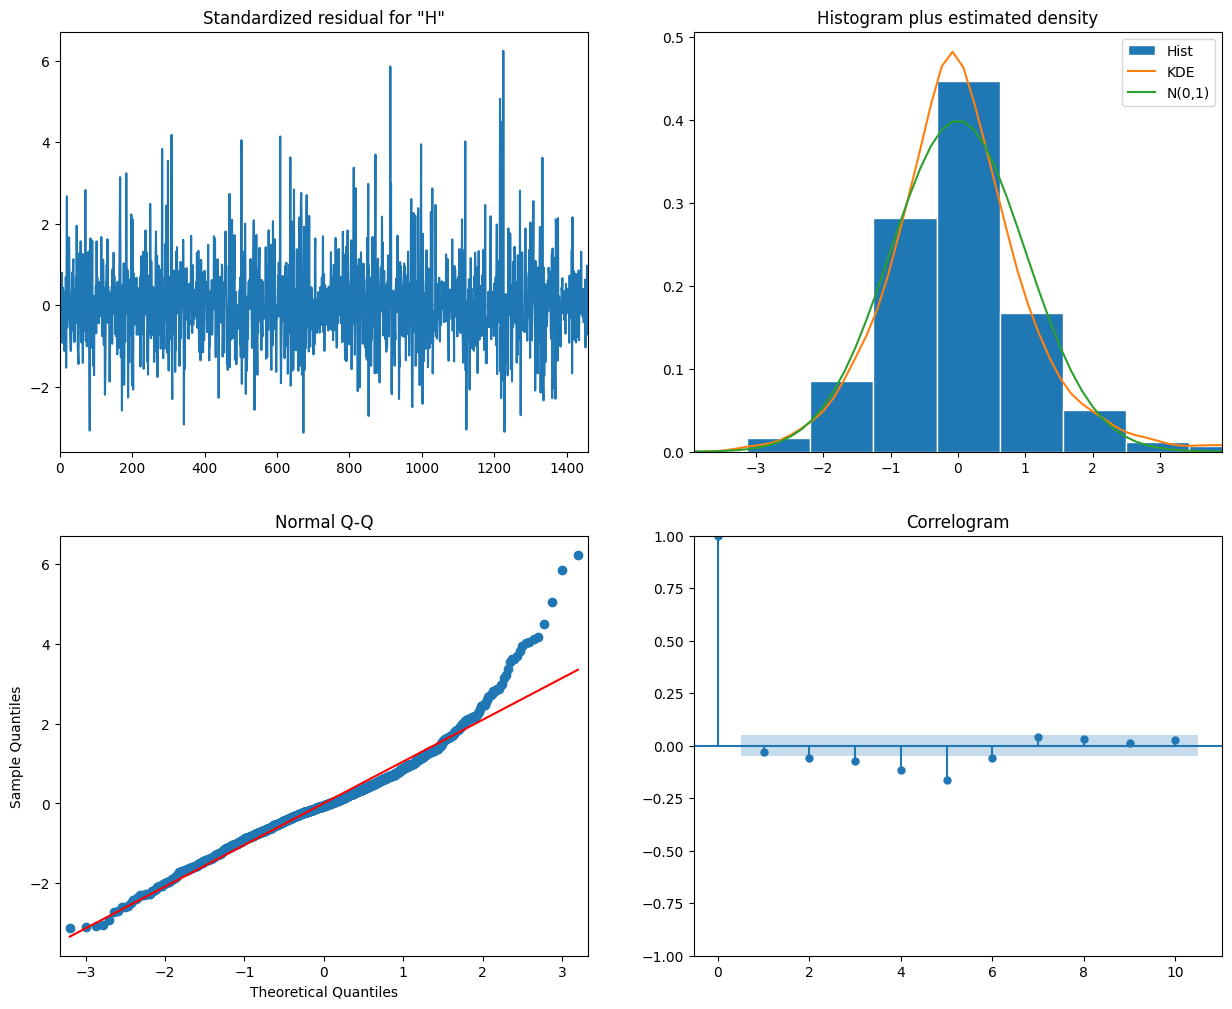

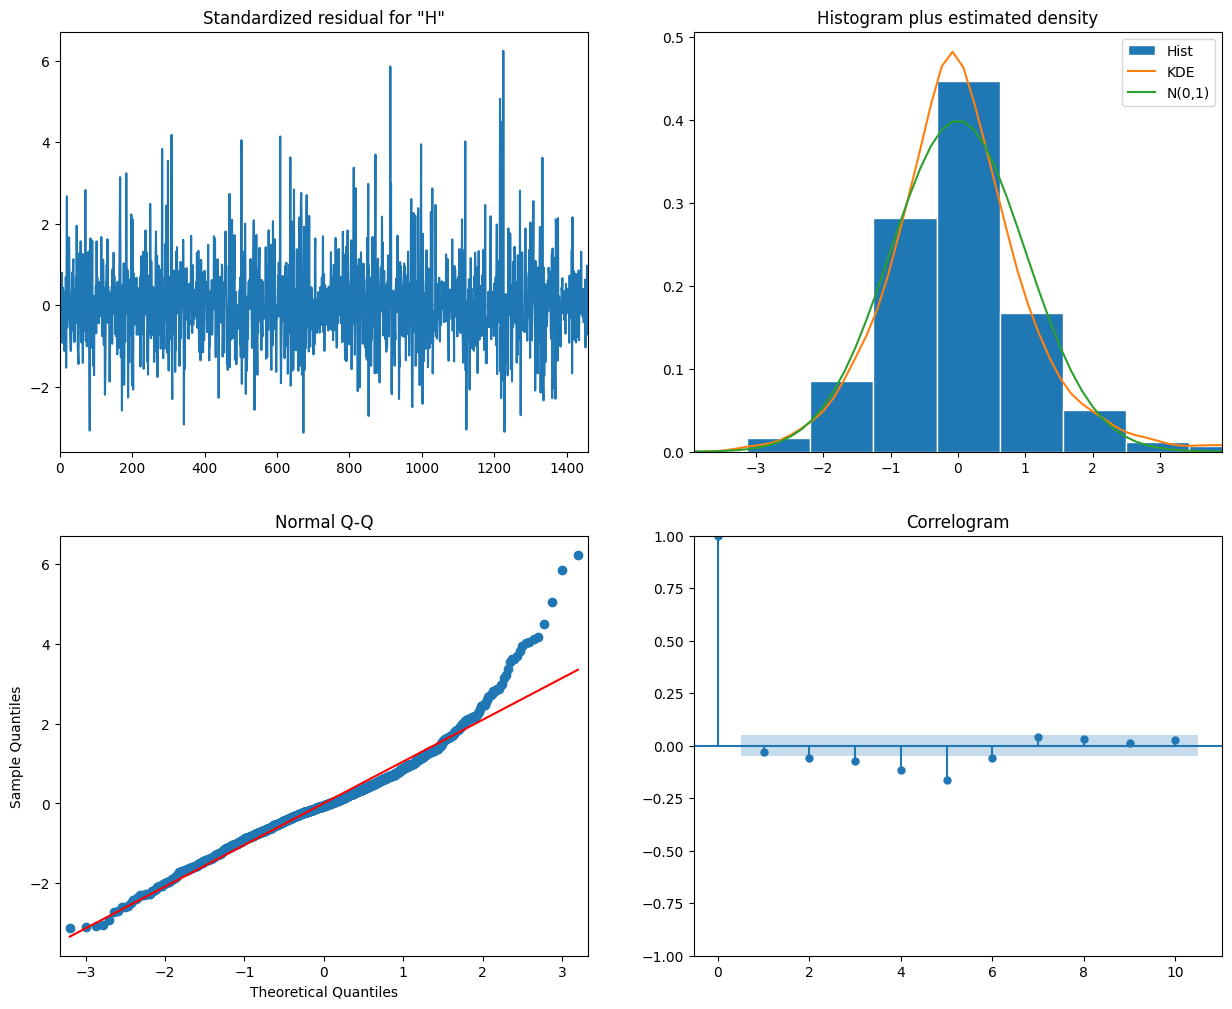

In [45]:
jaffna_model = auto_arima(jaffna_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = jaffna_model.order
print(p,d,q)
jaffna_sarima = SARIMAX(jaffna_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
jaffna_sarima_fit = jaffna_sarima.fit()
print(jaffna_sarima_fit.summary())
jaffna_sarima_fit.plot_diagnostics(figsize=(15,12))

In [46]:
jaffna_test_preds_sarima = jaffna_sarima_fit.forecast(steps=len(jaffna_test))
jaffna_sarima_mse = mean_squared_error(jaffna_test['HCHO_reading'], jaffna_test_preds_sarima)
print(f'SARIMA MSE for jaffna: {jaffna_sarima_mse}')
print(jaffna_test_preds_sarima)

SARIMA MSE for jaffna: 5.9643338479934015e-09
1460    0.000088
1461    0.000099
1462    0.000116
1463    0.000085
1464    0.000119
          ...   
1821    0.000054
1822    0.000060
1823    0.000047
1824    0.000062
1825    0.000049
Name: predicted_mean, Length: 366, dtype: float64


In [47]:
forcast_range = 30
forcasting_index = pd.date_range(start=jaffna['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = jaffna_sarima_fit.forecast(steps=forcast_range)
jaffna_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'jaffna'})
jaffna_forcast.set_index('Current_date',inplace=True)
jaffna_forcast

,HCHO_value,City
Current_date,,
2024-01-01,0.000088,jaffna
2024-01-02,0.000099,jaffna
2024-01-03,0.000116,jaffna
2024-01-04,0.000085,jaffna
2024-01-05,0.000119,jaffna
2024-01-06,0.000087,jaffna
2024-01-07,0.000097,jaffna
2024-01-08,0.000075,jaffna
2024-01-09,0.000105,jaffna


In [48]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

jaffna_forcast.to_csv('ForecastedPredictions/jaffna_forcast.csv')

## Kandy

In [49]:
Kandy = pd.read_csv('Kandy_Hcho_Reading.csv')
Kandy

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000176,Kandy,2019-01-01,2019-01-02,1,2019
1,0.000092,Kandy,2019-01-02,2019-01-03,1,2019
2,0.000095,Kandy,2019-01-03,2019-01-04,1,2019
3,0.000191,Kandy,2019-01-04,2019-01-05,1,2019
4,0.000122,Kandy,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000057,Kandy,2023-12-27,2023-12-28,12,2023
1822,0.000057,Kandy,2023-12-28,2023-12-29,12,2023
1823,0.000057,Kandy,2023-12-29,2023-12-30,12,2023
1824,0.000056,Kandy,2023-12-30,2023-12-31,12,2023


In [50]:
Kandy = remove_columns(Kandy)
convert_to_datetime(Kandy)
Kandy 

,HCHO_reading,Current_date
0,0.000176,2019-01-01
1,0.000092,2019-01-02
2,0.000095,2019-01-03
3,0.000191,2019-01-04
4,0.000122,2019-01-05
...,...,...
1821,0.000057,2023-12-27
1822,0.000057,2023-12-28
1823,0.000057,2023-12-29
1824,0.000056,2023-12-30


In [51]:
Kandy.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [52]:
split_Kandy = int(len(Kandy) * 0.8)
Kandy_train, Kandy_test = Kandy.iloc[:split_Kandy], Kandy.iloc[split_Kandy:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-23664.172, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23684.013, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-24088.515, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24376.247, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23685.812, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-24378.105, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-24376.979, Time=1.26 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-24374.217, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-24366.404, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-24399.322, Time=0.24 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-24397.994, Time=0.56 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-24396.930, Time=0.57 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=-24394.900, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-23669.165, Time=

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(0, 1, 5)x(0, 1, 5, 12)   Log Likelihood               11620.487
Date:                            Fri, 19 Apr 2024   AIC                         -23218.973
Time:                                    09:43:33   BIC                         -23160.923
Sample:                                         0   HQIC                        -23197.308
                                           - 1460                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7876   4.64e-20   -1.7e+19      0.000      -0.788      -0.788
ma.L2          0.0521   1.54e-19   

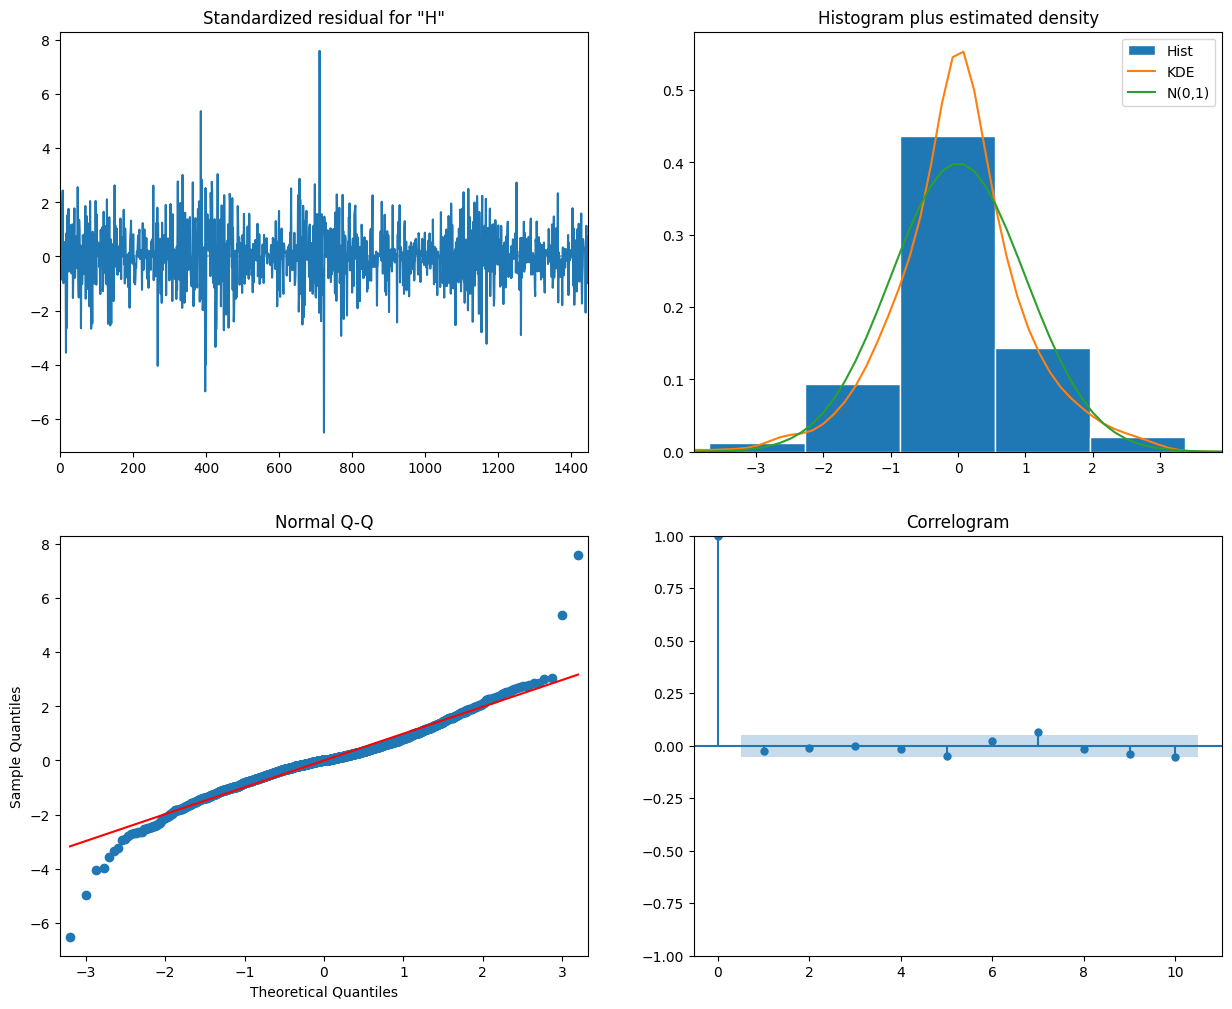

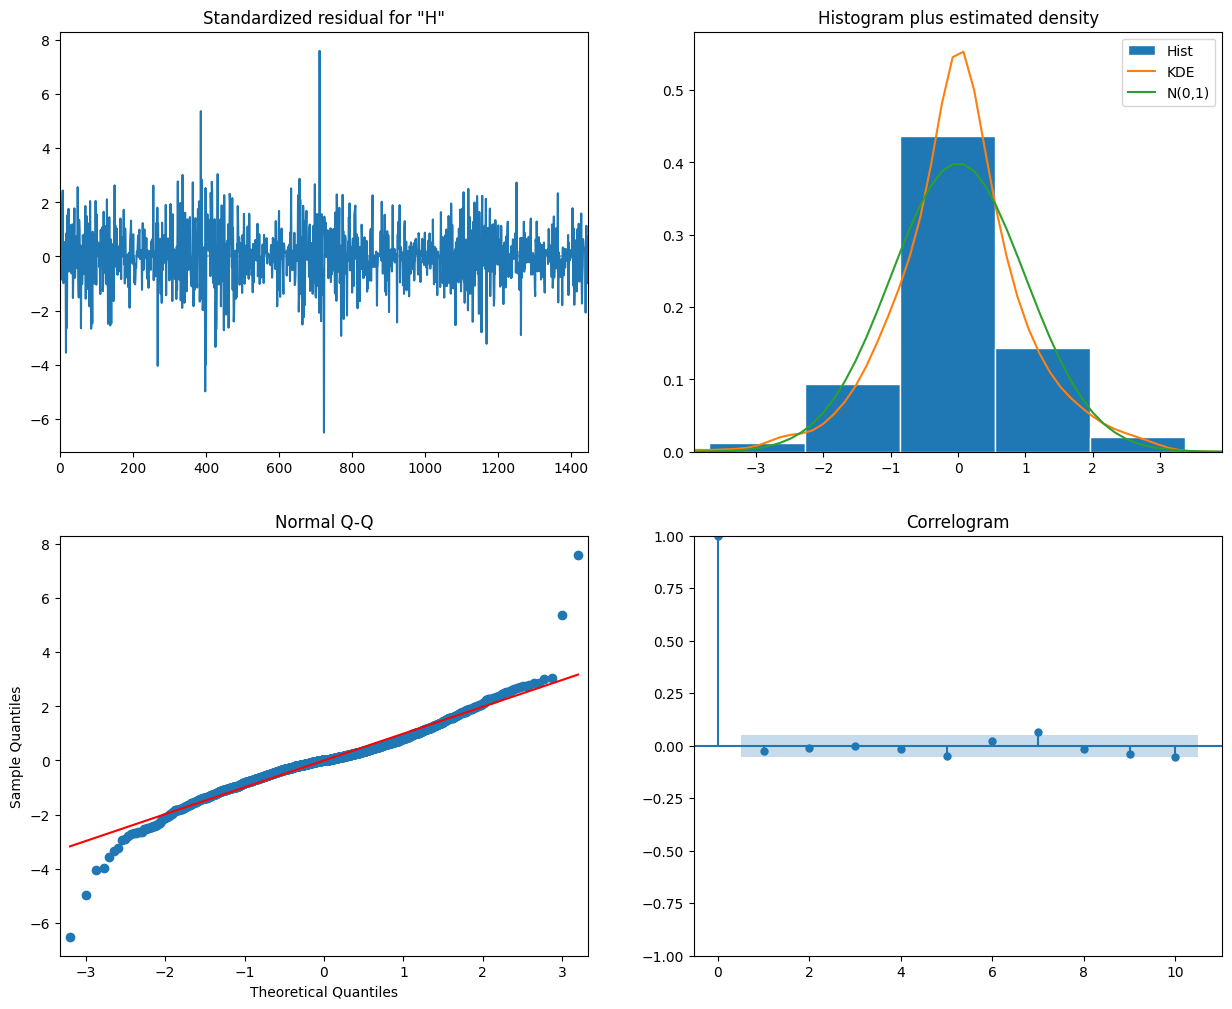

In [53]:
Kandy_model = auto_arima(Kandy_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = Kandy_model.order
print(p,d,q)
Kandy_sarima = SARIMAX(Kandy_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
Kandy_sarima_fit = Kandy_sarima.fit()
print(Kandy_sarima_fit.summary())
Kandy_sarima_fit.plot_diagnostics(figsize=(15,12))

In [54]:
Kandy_test_preds_sarima = Kandy_sarima_fit.forecast(steps=len(Kandy_test))
Kandy_sarima_mse = mean_squared_error(Kandy_test['HCHO_reading'], Kandy_test_preds_sarima)
print(f'SARIMA MSE for Kandy: {Kandy_sarima_mse}')
print(Kandy_test_preds_sarima)

SARIMA MSE for Kandy: 3.9064041629349245e-07
1460    0.000057
1461    0.000057
1462    0.000063
1463    0.000064
1464    0.000062
          ...   
1821   -0.000942
1822   -0.000937
1823   -0.000936
1824   -0.000938
1825   -0.000938
Name: predicted_mean, Length: 366, dtype: float64


In [55]:
forcast_range = 30
forcasting_index = pd.date_range(start=Kandy['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = Kandy_sarima_fit.forecast(steps=forcast_range)
Kandy_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'Kandy'})
Kandy_forcast.set_index('Current_date',inplace=True)
Kandy_forcast

,HCHO_value,City
Current_date,,
2024-01-01,0.000057,Kandy
2024-01-02,0.000057,Kandy
2024-01-03,0.000063,Kandy
2024-01-04,0.000064,Kandy
2024-01-05,0.000062,Kandy
2024-01-06,0.000062,Kandy
2024-01-07,0.000062,Kandy
2024-01-08,0.000062,Kandy
2024-01-09,0.000036,Kandy


In [56]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

Kandy_forcast.to_csv('ForecastedPredictions/kandy_forcast.csv')

## Kurunagala


In [58]:
kurunagala = pd.read_csv('Kurunegala_Hcho_Reading.csv')
kurunagala

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000088,Kurunegala,2019-01-01,2019-01-02,1,2019
1,0.000137,Kurunegala,2019-01-02,2019-01-03,1,2019
2,0.000148,Kurunegala,2019-01-03,2019-01-04,1,2019
3,0.000152,Kurunegala,2019-01-04,2019-01-05,1,2019
4,0.000249,Kurunegala,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000075,Kurunegala,2023-12-27,2023-12-28,12,2023
1822,0.000094,Kurunegala,2023-12-28,2023-12-29,12,2023
1823,0.000094,Kurunegala,2023-12-29,2023-12-30,12,2023
1824,0.000158,Kurunegala,2023-12-30,2023-12-31,12,2023


In [59]:
kurunagala = remove_columns(kurunagala)
convert_to_datetime(kurunagala)
kurunagala 

,HCHO_reading,Current_date
0,0.000088,2019-01-01
1,0.000137,2019-01-02
2,0.000148,2019-01-03
3,0.000152,2019-01-04
4,0.000249,2019-01-05
...,...,...
1821,0.000075,2023-12-27
1822,0.000094,2023-12-28
1823,0.000094,2023-12-29
1824,0.000158,2023-12-30


In [60]:
kurunagala.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [61]:
split_kurunagala = int(len(kurunagala) * 0.8)
kurunagala_train, kurunagala_test = kurunagala.iloc[:split_kurunagala], kurunagala.iloc[split_kurunagala:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-24235.030, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23523.721, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23850.856, Time=1.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24161.031, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23525.719, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-24237.693, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-24237.325, Time=0.34 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-24240.248, Time=1.92 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-24238.421, Time=2.14 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-24232.746, Time=1.76 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=-24203.843, Time=34.11 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=-24228.482, Time=16.44 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=-24241.296, Time=9.77 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-24238.464, Tim

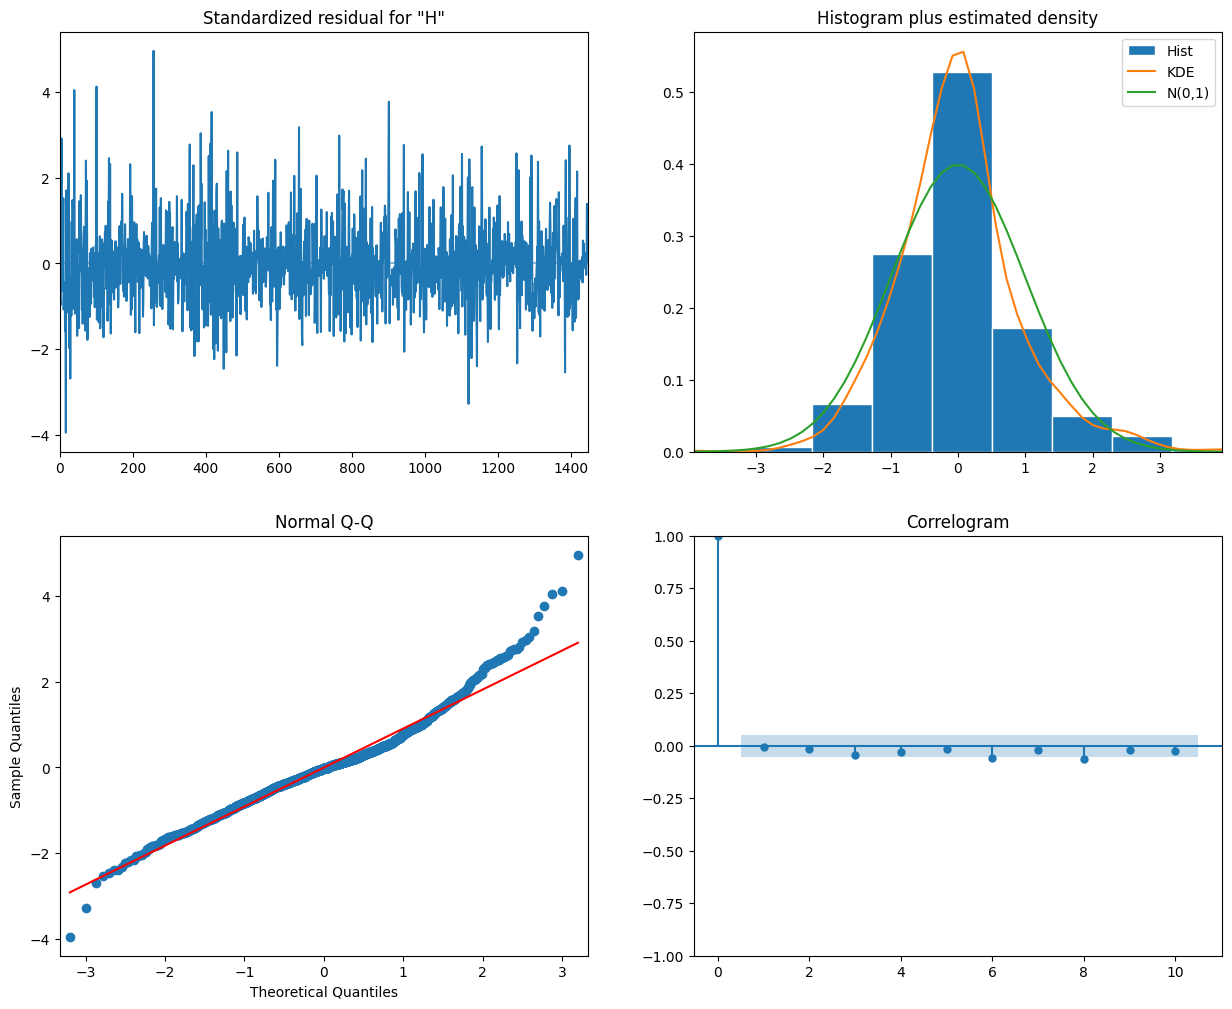

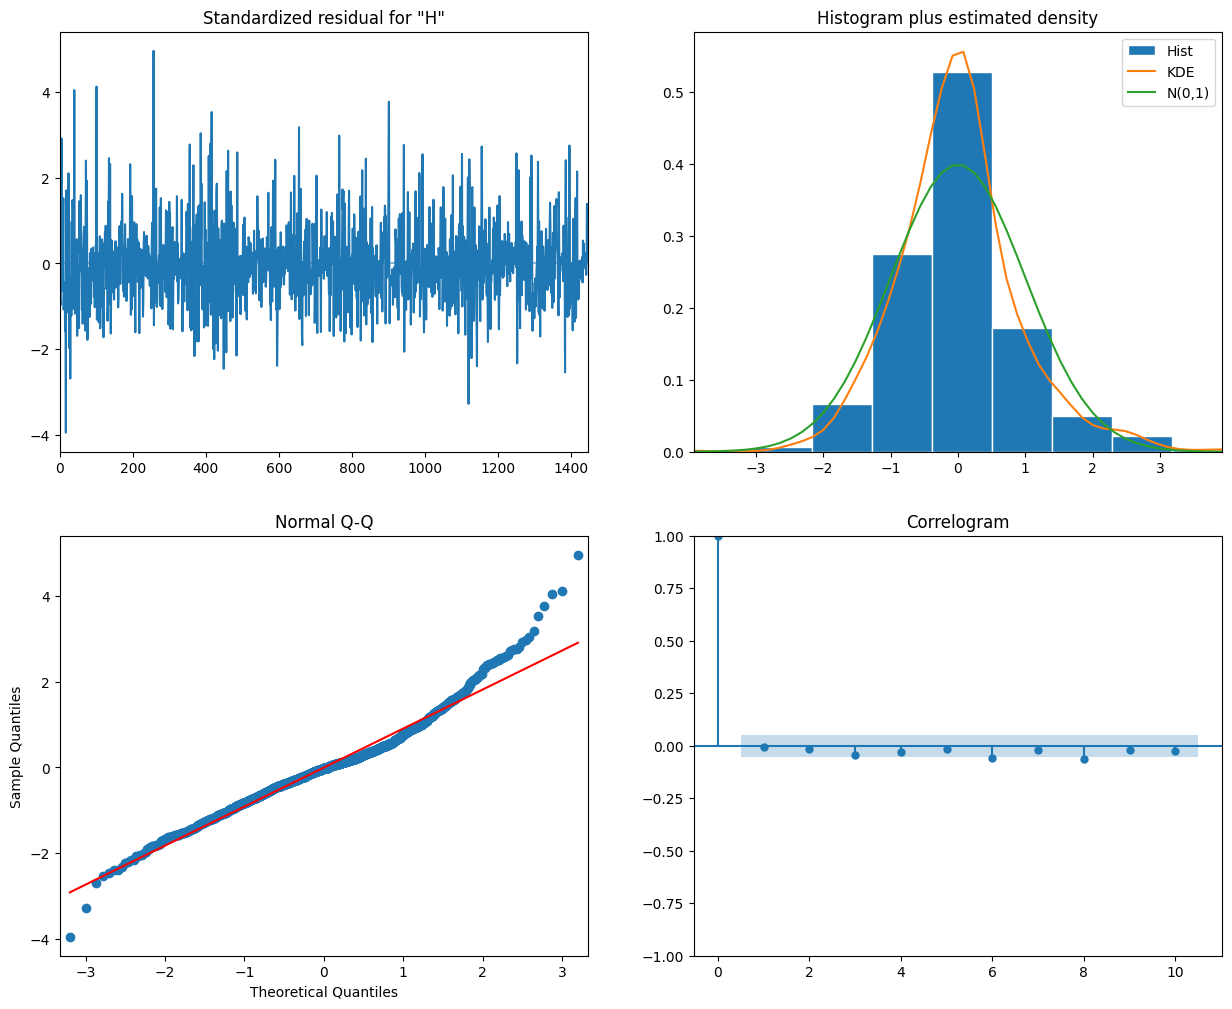

In [62]:
kurunagala_model = auto_arima(kurunagala_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = kurunagala_model.order
print(p,d,q)
kurunagala_sarima = SARIMAX(kurunagala_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
kurunagala_sarima_fit = kurunagala_sarima.fit()
print(kurunagala_sarima_fit.summary())
kurunagala_sarima_fit.plot_diagnostics(figsize=(15,12))

In [63]:
kurunagala_test_preds_sarima = kurunagala_sarima_fit.forecast(steps=len(kurunagala_test))
kurunagala_sarima_mse = mean_squared_error(kurunagala_test['HCHO_reading'], kurunagala_test_preds_sarima)
print(f'SARIMA MSE for kurunagala: {kurunagala_sarima_mse}')
print(kurunagala_test_preds_sarima)

SARIMA MSE for kurunagala: 5.764724751464019e-09
1460    0.000131
1461    0.000152
1462    0.000126
1463    0.000131
1464    0.000139
          ...   
1821    0.000187
1822    0.000166
1823    0.000169
1824    0.000176
1825    0.000184
Name: predicted_mean, Length: 366, dtype: float64


In [64]:
forcast_range = 30
forcasting_index = pd.date_range(start=kurunagala['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = kurunagala_sarima_fit.forecast(steps=forcast_range)
kurunagala_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'kurunagala'})
kurunagala_forcast.set_index('Current_date',inplace=True)
kurunagala_forcast

,HCHO_value,City
Current_date,,
2024-01-01,0.000131,kurunagala
2024-01-02,0.000152,kurunagala
2024-01-03,0.000126,kurunagala
2024-01-04,0.000131,kurunagala
2024-01-05,0.000139,kurunagala
2024-01-06,0.000150,kurunagala
2024-01-07,0.000154,kurunagala
2024-01-08,0.000134,kurunagala
2024-01-09,0.000152,kurunagala


In [65]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

kurunagala_forcast.to_csv('ForecastedPredictions/kurunagala_forcast.csv')

## Matara


In [68]:
Matara = pd.read_csv('Matara_Hcho_Reading.csv')
Matara

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000130,Matara,2019-01-01,2019-01-02,1,2019
1,0.000006,Matara,2019-01-02,2019-01-03,1,2019
2,0.000236,Matara,2019-01-03,2019-01-04,1,2019
3,0.000064,Matara,2019-01-04,2019-01-05,1,2019
4,0.000053,Matara,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000228,Matara,2023-12-27,2023-12-28,12,2023
1822,0.000096,Matara,2023-12-28,2023-12-29,12,2023
1823,0.000096,Matara,2023-12-29,2023-12-30,12,2023
1824,0.000116,Matara,2023-12-30,2023-12-31,12,2023


In [69]:
Matara = remove_columns(Matara)
convert_to_datetime(Matara)
Matara 

,HCHO_reading,Current_date
0,0.000130,2019-01-01
1,0.000006,2019-01-02
2,0.000236,2019-01-03
3,0.000064,2019-01-04
4,0.000053,2019-01-05
...,...,...
1821,0.000228,2023-12-27
1822,0.000096,2023-12-28
1823,0.000096,2023-12-29
1824,0.000116,2023-12-30


In [70]:
Matara.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [71]:
split_Mathara = int(len(Matara) * 0.8)
Mathara_train, Mathara_test = Matara.iloc[:split_Mathara], Matara.iloc[split_Mathara:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-24075.633, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23280.412, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23658.243, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-23973.934, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23282.335, Time=0.13 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-24077.637, Time=1.69 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-24079.365, Time=0.81 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-24076.315, Time=1.73 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-24060.641, Time=3.04 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-24005.962, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-24078.131, Time=0.90 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-23264.021, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-23983.519, Time=1.73 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-24083.844, Time=

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(2, 1, 4)x(2, 1, 4, 12)   Log Likelihood               11465.351
Date:                            Fri, 19 Apr 2024   AIC                         -22904.701
Time:                                    09:58:23   BIC                         -22836.097
Sample:                                         0   HQIC                        -22879.097
                                           - 1460                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0   7.87e-19         -0      1.000   -1.54e-18    1.54e-18
ar.L2               0   1.56e-20   

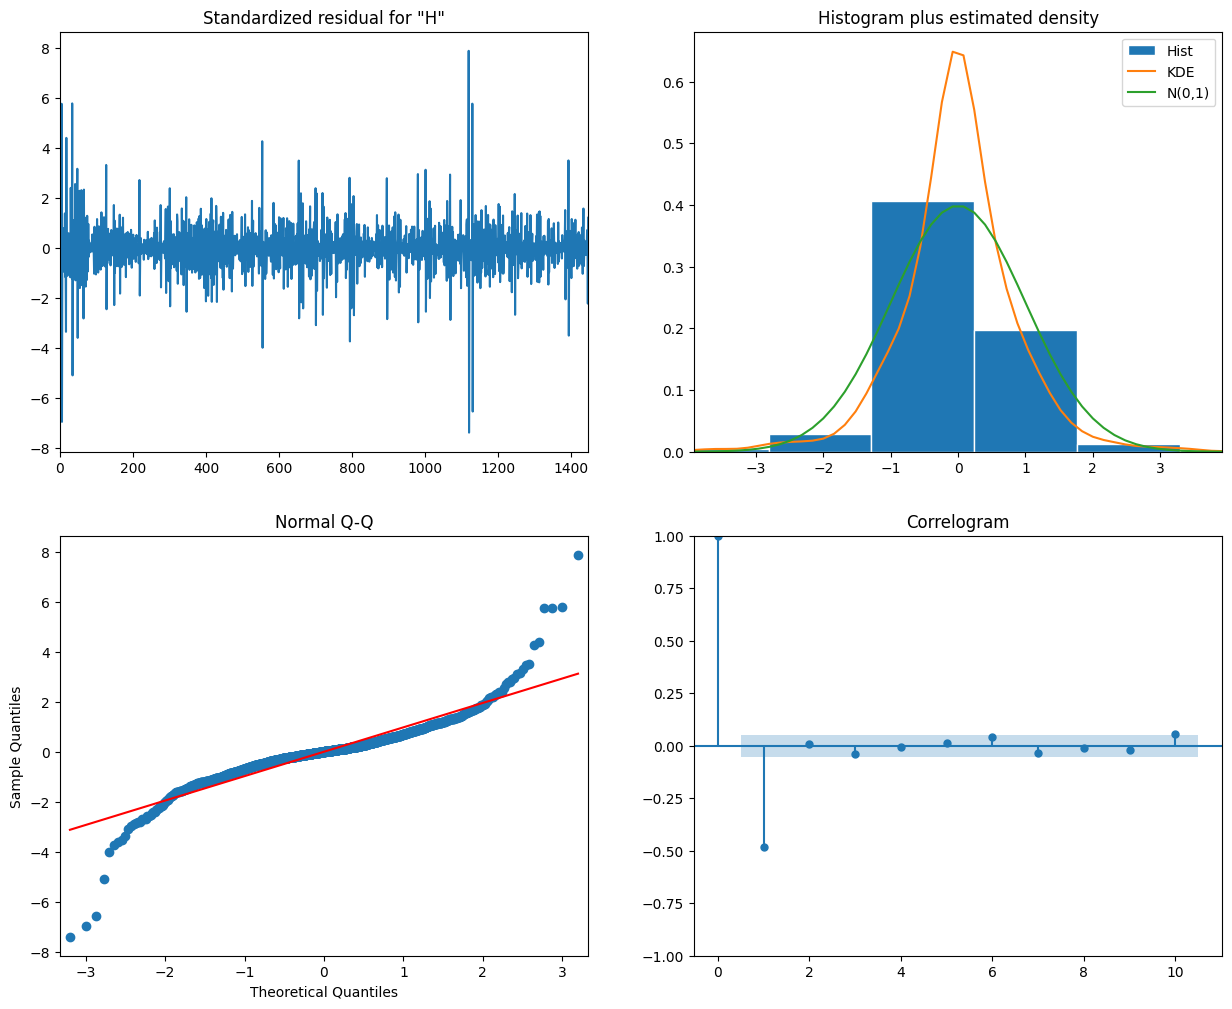

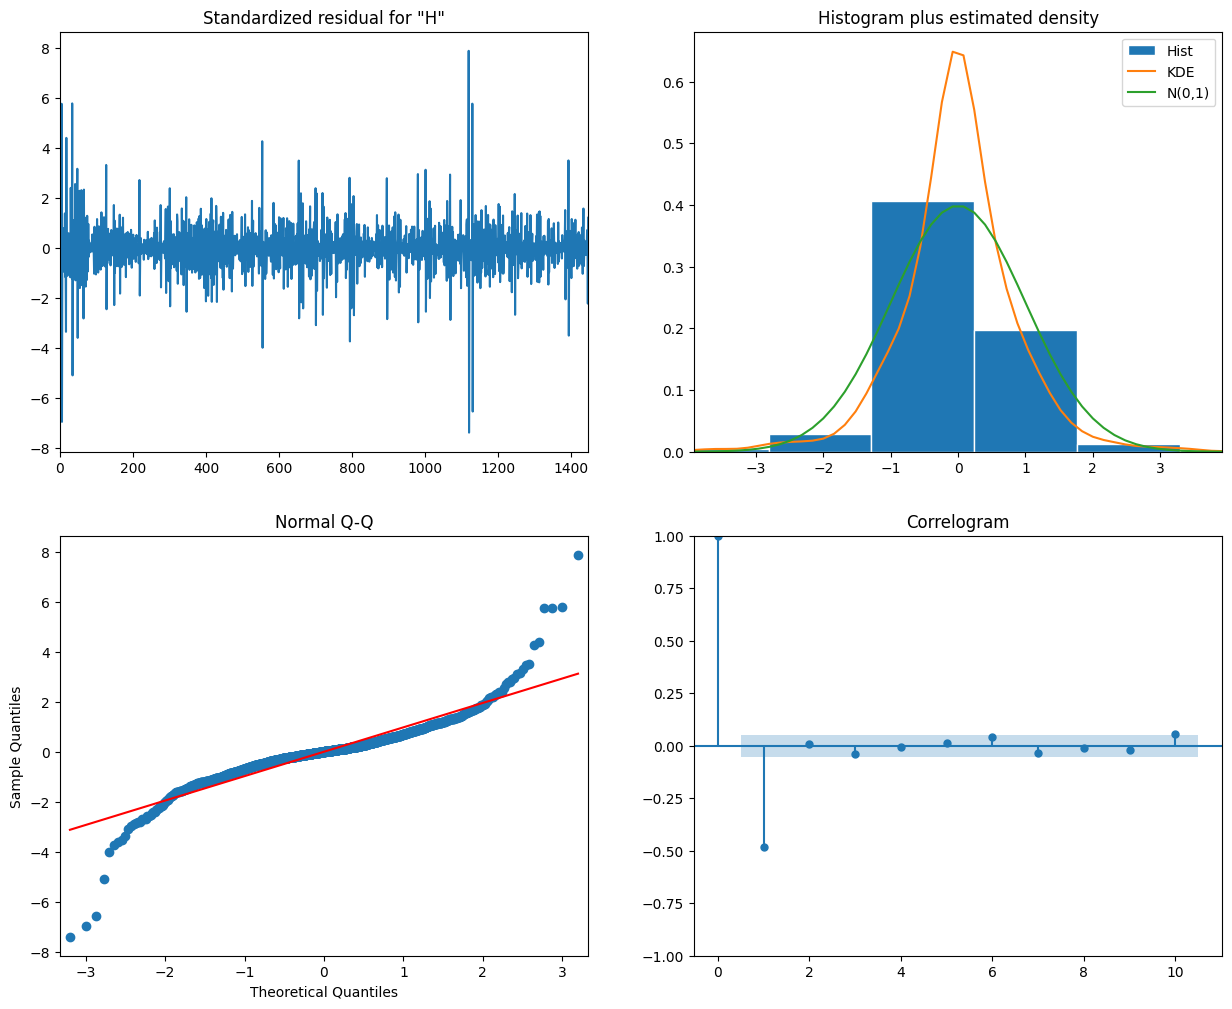

In [72]:
Mathara_model = auto_arima(Mathara_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = Mathara_model.order
print(p,d,q)
Mathara_sarima = SARIMAX(Mathara_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
Mathara_sarima_fit = Mathara_sarima.fit()
print(Mathara_sarima_fit.summary())
Mathara_sarima_fit.plot_diagnostics(figsize=(15,12))

In [73]:
Mathara_test_preds_sarima = Mathara_sarima_fit.forecast(steps=len(Mathara_test))
Mathara_sarima_mse = mean_squared_error(Mathara_test['HCHO_reading'], Mathara_test_preds_sarima)
print(f'SARIMA MSE for Mathara: {Mathara_sarima_mse}')
print(Mathara_test_preds_sarima)

SARIMA MSE for Mathara: 7.500710584762633e-09
1460    0.000117
1461    0.000100
1462    0.000114
1463    0.000108
1464    0.000110
          ...   
1821    0.000173
1822    0.000191
1823    0.000185
1824    0.000185
1825    0.000210
Name: predicted_mean, Length: 366, dtype: float64


In [74]:
forcast_range = 30
forcasting_index = pd.date_range(start=Kandy['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = Mathara_sarima_fit.forecast(steps=forcast_range)
Mathara_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'Mathara'})
Mathara_forcast.set_index('Current_date',inplace=True)
Mathara_forcast

,HCHO_value,City
Current_date,,
2024-01-01,0.000117,Mathara
2024-01-02,0.000100,Mathara
2024-01-03,0.000114,Mathara
2024-01-04,0.000108,Mathara
2024-01-05,0.000110,Mathara
2024-01-06,0.000136,Mathara
2024-01-07,0.000109,Mathara
2024-01-08,0.000105,Mathara
2024-01-09,0.000111,Mathara


In [75]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

Mathara_forcast.to_csv('ForecastedPredictions/Mathara_forcast.csv')

## Monaragala

In [76]:
Monaragala = pd.read_csv('Monaragala_Hcho_Reading.csv')
Monaragala

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000079,Monaragala,2019-01-01,2019-01-02,1,2019
1,0.000019,Monaragala,2019-01-02,2019-01-03,1,2019
2,0.000028,Monaragala,2019-01-03,2019-01-04,1,2019
3,0.000037,Monaragala,2019-01-04,2019-01-05,1,2019
4,0.000086,Monaragala,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000057,Monaragala,2023-12-27,2023-12-28,12,2023
1822,0.000057,Monaragala,2023-12-28,2023-12-29,12,2023
1823,0.000057,Monaragala,2023-12-29,2023-12-30,12,2023
1824,0.000057,Monaragala,2023-12-30,2023-12-31,12,2023


In [77]:
Monaragala = remove_columns(Monaragala)
convert_to_datetime(Monaragala)
Monaragala 

,HCHO_reading,Current_date
0,0.000079,2019-01-01
1,0.000019,2019-01-02
2,0.000028,2019-01-03
3,0.000037,2019-01-04
4,0.000086,2019-01-05
...,...,...
1821,0.000057,2023-12-27
1822,0.000057,2023-12-28
1823,0.000057,2023-12-29
1824,0.000057,2023-12-30


In [78]:
Monaragala.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [79]:
split_Monaragala = int(len(Monaragala) * 0.8)
Monaragala_train, Monaragala_test = Monaragala.iloc[:split_Monaragala], Monaragala.iloc[split_Monaragala:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-23880.697, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23397.855, Time=1.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-23955.458, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-21656.199, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-23924.922, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-23960.958, Time=3.31 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-23921.827, Time=2.18 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-24075.513, Time=3.15 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24075.211, Time=1.51 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.53 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(1,0,0)(0,0,2)[12] i

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(5, 0, 0)x(5, 0, 0, 12)   Log Likelihood               11894.362
Date:                            Fri, 19 Apr 2024   AIC                         -23766.725
Time:                                    10:00:03   BIC                         -23708.577
Sample:                                         0   HQIC                        -23745.033
                                           - 1460                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2427   3.64e-20   6.67e+18      0.000       0.243       0.243
ar.L2          0.2017   3.91e-20   

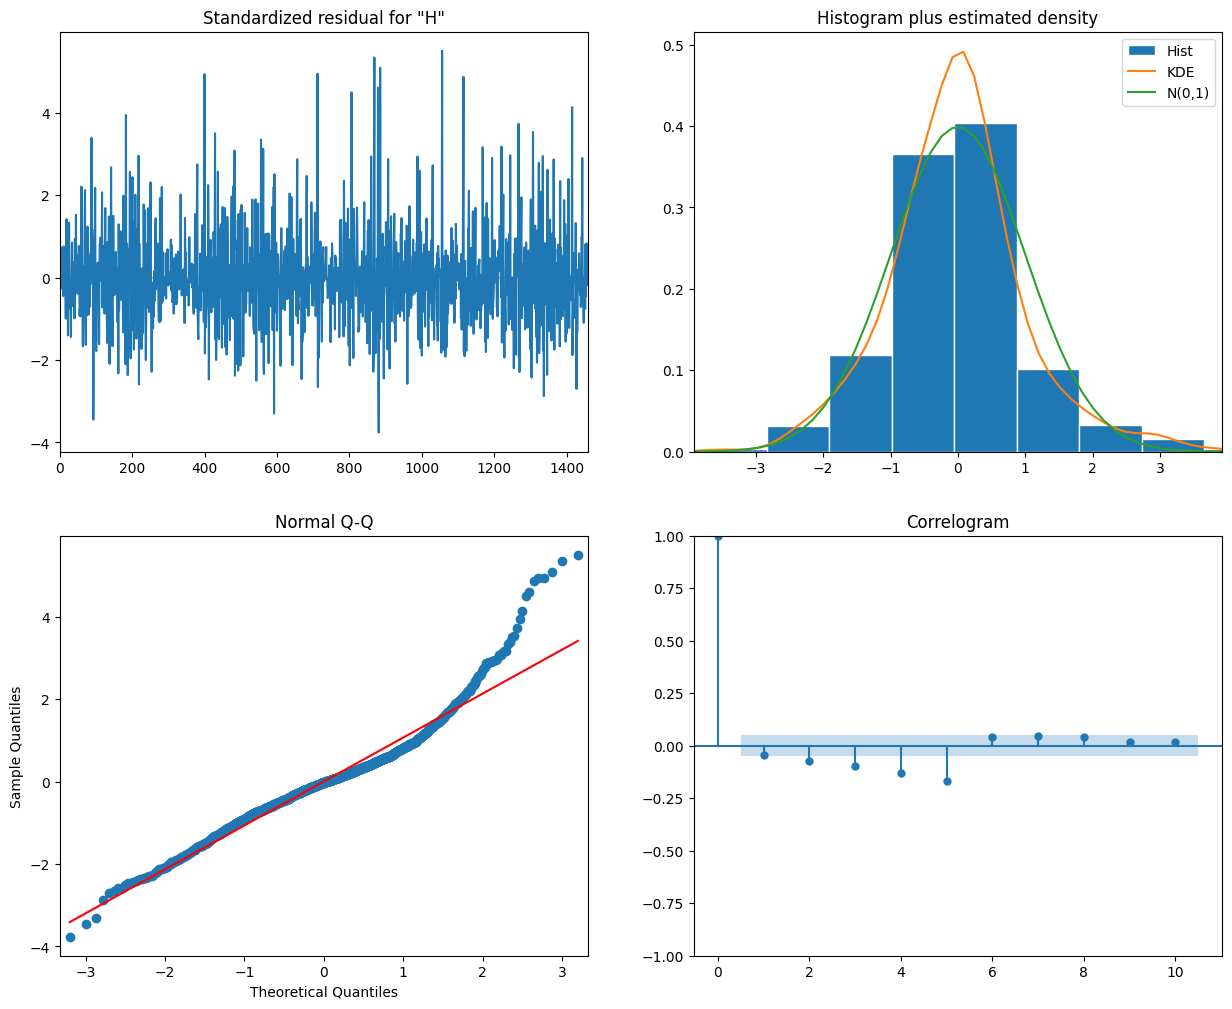

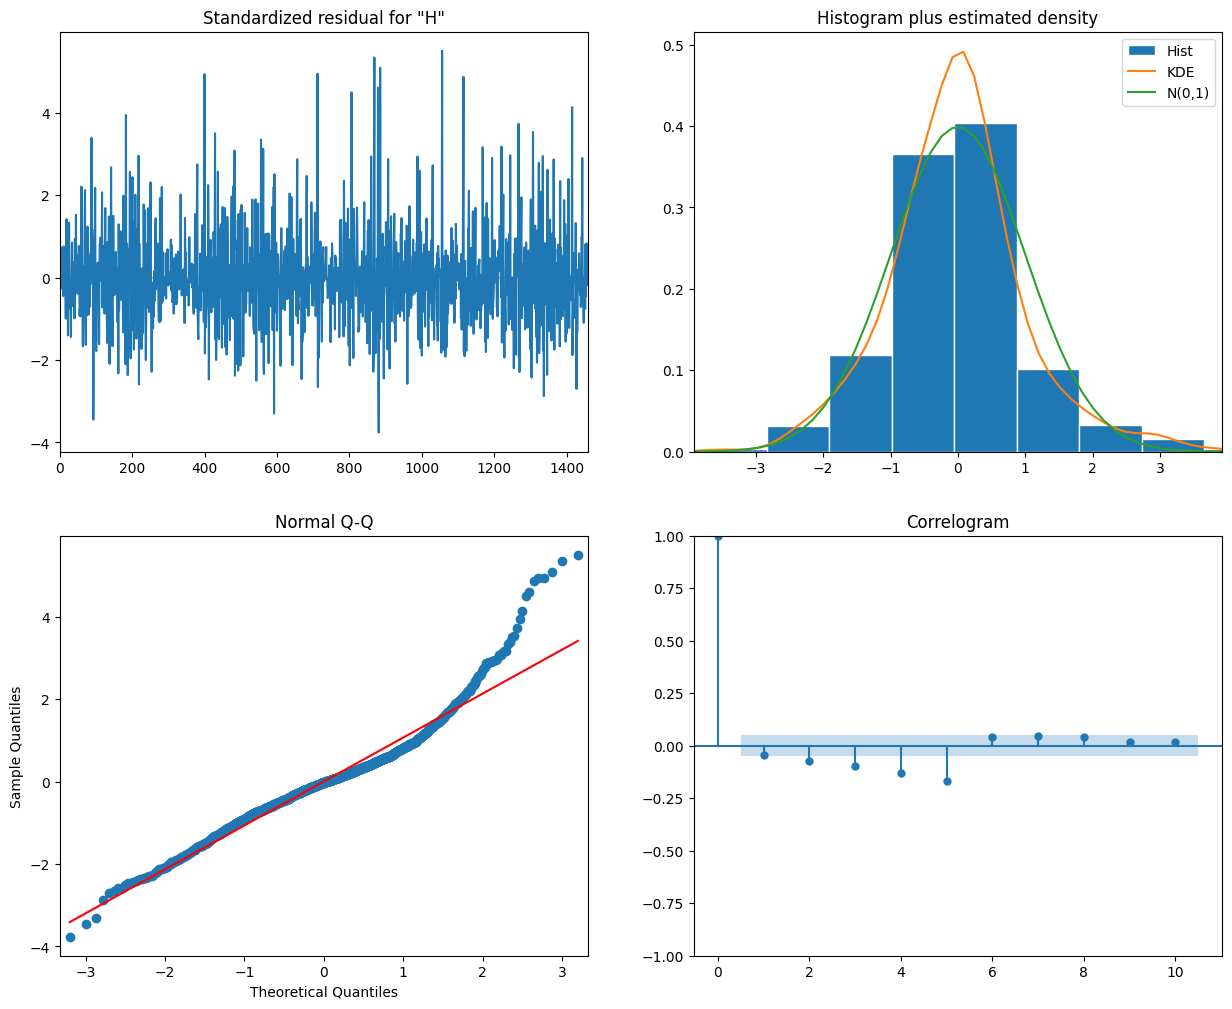

In [80]:
Monaragala_model = auto_arima(Monaragala_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = Monaragala_model.order
print(p,d,q)
Monaragala_sarima = SARIMAX(Monaragala_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
Monaragala_sarima_fit = Monaragala_sarima.fit()
print(Monaragala_sarima_fit.summary())
Monaragala_sarima_fit.plot_diagnostics(figsize=(15,12))

In [81]:
Monaragala_test_preds_sarima = Monaragala_sarima_fit.forecast(steps=len(Monaragala_test))
Monaragala_sarima_mse = mean_squared_error(Monaragala_test['HCHO_reading'], Monaragala_test_preds_sarima)
print(f'SARIMA MSE for kurunagala: {Monaragala_sarima_mse}')
print(Monaragala_test_preds_sarima)

SARIMA MSE for kurunagala: 1.3372134283088068e-08
1460    0.000067
1461    0.000085
1462    0.000068
1463    0.000139
1464    0.000056
          ...   
1821    0.000034
1822    0.000021
1823    0.000046
1824    0.000017
1825    0.000024
Name: predicted_mean, Length: 366, dtype: float64


In [82]:
forcast_range = 30
forcasting_index = pd.date_range(start=Monaragala['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = Monaragala_sarima_fit.forecast(steps=forcast_range)
Monaragala_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'Monaragala'})
Monaragala_forcast.set_index('Current_date',inplace=True)
Monaragala_forcast

,HCHO_value,City
Current_date,,
2024-01-01,0.000067,Monaragala
2024-01-02,0.000085,Monaragala
2024-01-03,0.000068,Monaragala
2024-01-04,0.000139,Monaragala
2024-01-05,0.000056,Monaragala
2024-01-06,0.000082,Monaragala
2024-01-07,0.000067,Monaragala
2024-01-08,0.000086,Monaragala
2024-01-09,0.000104,Monaragala


In [83]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

Monaragala_forcast.to_csv('ForecastedPredictions/Monaragala_forcast.csv')

## Nuwara eliya

In [84]:
Nuwara_eliya = pd.read_csv('Nuwara Eliya_Hcho_Reading.csv')
Nuwara_eliya

,HCHO_reading,Location,Current_date,Next_date,Month,Year
0,0.000088,Nuwara Eliya,2019-01-01,2019-01-02,1,2019
1,0.000088,Nuwara Eliya,2019-01-02,2019-01-03,1,2019
2,0.000191,Nuwara Eliya,2019-01-03,2019-01-04,1,2019
3,0.000051,Nuwara Eliya,2019-01-04,2019-01-05,1,2019
4,0.000065,Nuwara Eliya,2019-01-05,2019-01-06,1,2019
...,...,...,...,...,...,...
1821,0.000043,Nuwara Eliya,2023-12-27,2023-12-28,12,2023
1822,0.000043,Nuwara Eliya,2023-12-28,2023-12-29,12,2023
1823,0.000043,Nuwara Eliya,2023-12-29,2023-12-30,12,2023
1824,0.000043,Nuwara Eliya,2023-12-30,2023-12-31,12,2023


In [85]:
Nuwara_eliya = remove_columns(Nuwara_eliya)
convert_to_datetime(Nuwara_eliya)
Nuwara_eliya 


,HCHO_reading,Current_date
0,0.000088,2019-01-01
1,0.000088,2019-01-02
2,0.000191,2019-01-03
3,0.000051,2019-01-04
4,0.000065,2019-01-05
...,...,...
1821,0.000043,2023-12-27
1822,0.000043,2023-12-28
1823,0.000043,2023-12-29
1824,0.000043,2023-12-30


In [86]:
Nuwara_eliya.dtypes

HCHO_reading           float64
Current_date    datetime64[ns]
dtype: object

In [87]:
split_Nuwara_eliya = int(len(Nuwara_eliya) * 0.8)
Nuwara_eliya_train, Nuwara_eliya_test = Nuwara_eliya.iloc[:split_Nuwara_eliya], Nuwara_eliya.iloc[split_Nuwara_eliya:]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-25026.051, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-24318.190, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-24624.987, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24928.800, Time=3.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-24319.712, Time=0.20 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-25028.132, Time=0.77 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-25029.220, Time=0.35 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-25028.022, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-25028.130, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-24951.981, Time=1.83 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-25021.493, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-25022.673, Time=1.77 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-24973.679, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-25028.439, Time=

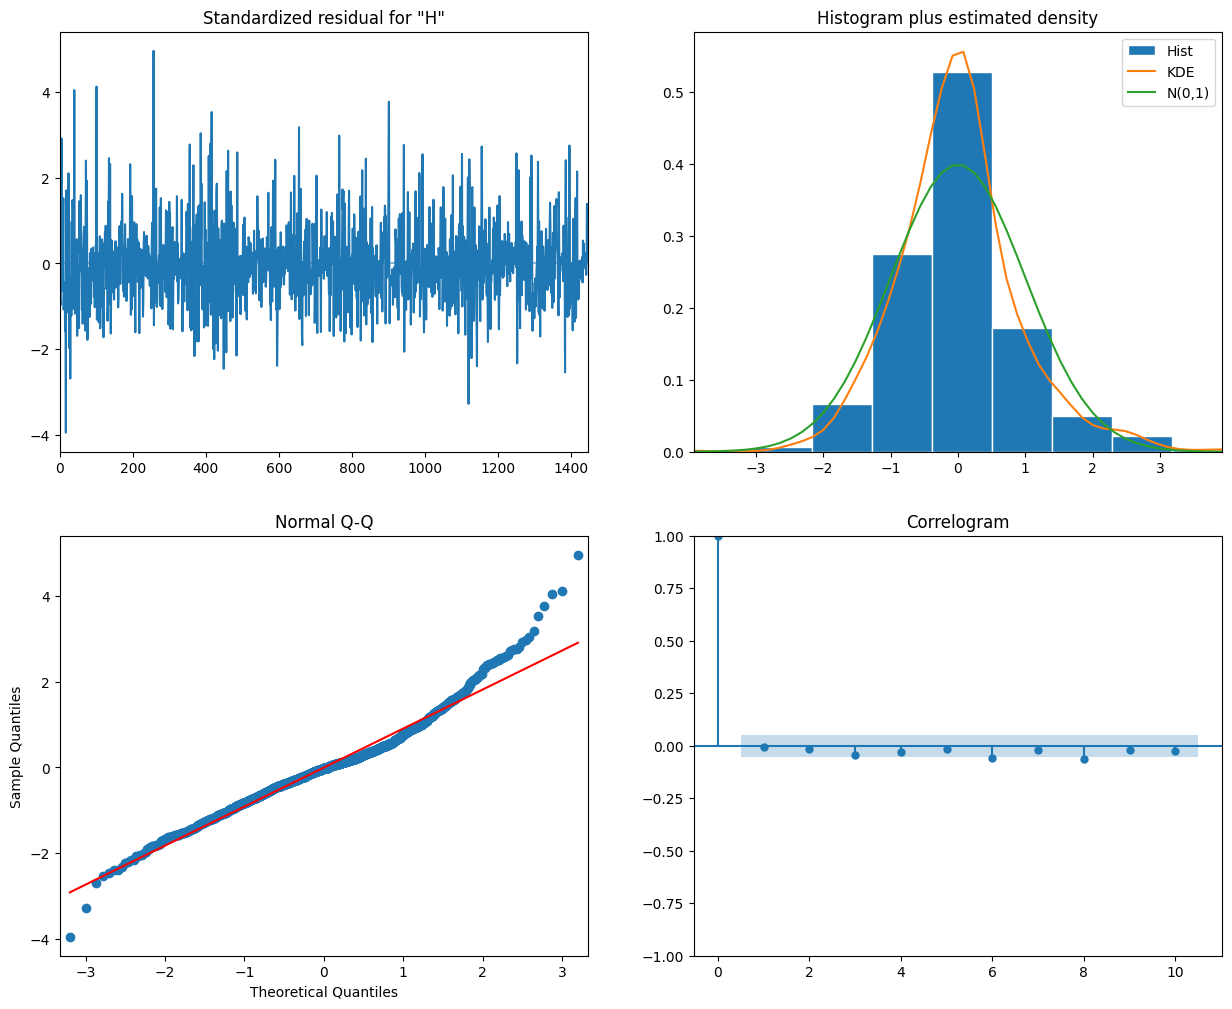

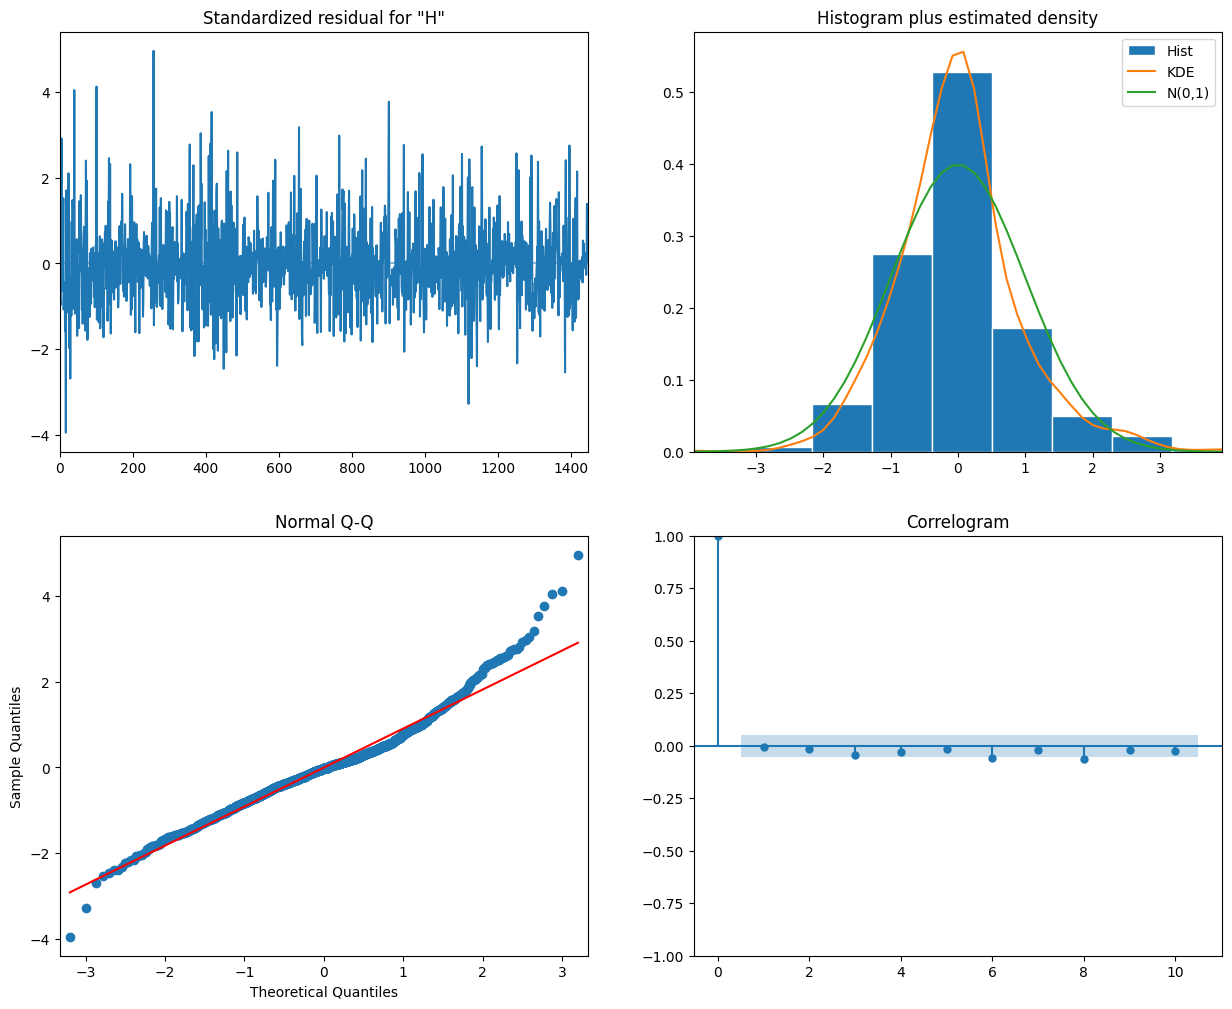

In [88]:
Nuwara_eliya_model = auto_arima(Nuwara_eliya_train['HCHO_reading'], seasonal=True, trace=True, m=12)
p,d,q = Nuwara_eliya_model.order
print(p,d,q)
Nuwara_eliya_sarima = SARIMAX(Nuwara_eliya_train['HCHO_reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
Nuwara_eliya_sarima_fit = kurunagala_sarima.fit()
print(Nuwara_eliya_sarima_fit.summary())
Nuwara_eliya_sarima_fit.plot_diagnostics(figsize=(15,12))

In [89]:
Nuwara_eliya_test_preds_sarima = Nuwara_eliya_sarima_fit.forecast(steps=len(Nuwara_eliya_test))
Nuwara_eliya_sarima_mse = mean_squared_error(Nuwara_eliya_test['HCHO_reading'], Nuwara_eliya_test_preds_sarima)
print(f'SARIMA MSE for Nuwara Eliya: {Nuwara_eliya_sarima_mse}')
print(Nuwara_eliya_test_preds_sarima)

SARIMA MSE for Nuwara Eliya: 7.910095527609874e-09
1460    0.000131
1461    0.000152
1462    0.000126
1463    0.000131
1464    0.000139
          ...   
1821    0.000187
1822    0.000166
1823    0.000169
1824    0.000176
1825    0.000184
Name: predicted_mean, Length: 366, dtype: float64


In [90]:
forcast_range = 30
forcasting_index = pd.date_range(start=Nuwara_eliya['Current_date'].max(),periods=forcast_range+1,freq='D')[1:]
forcasted_HCHO = Nuwara_eliya_sarima_fit.forecast(steps=forcast_range)
Nuwara_eliya_forcast = pd.DataFrame({'Current_date': forcasting_index, 'HCHO_value': forcasted_HCHO, 'City':'Nuwara Eliya'})
Nuwara_eliya_forcast.set_index('Current_date',inplace=True)
Nuwara_eliya

,HCHO_reading,Current_date
0,0.000088,2019-01-01
1,0.000088,2019-01-02
2,0.000191,2019-01-03
3,0.000051,2019-01-04
4,0.000065,2019-01-05
...,...,...
1821,0.000043,2023-12-27
1822,0.000043,2023-12-28
1823,0.000043,2023-12-29
1824,0.000043,2023-12-30


In [91]:
folder = 'ForecastedPredictions'

if not os.path.exists(folder):
    os.makedirs(folder)

Nuwara_eliya_forcast.to_csv('ForecastedPredictions/Nuwara Eliya_forcast.csv')